# Unsupervised Learning and Dimensionality Reduction

Things to do:
 - Rerun the Neural Network on the Adult Data using all samples and a scaler
 - Run k-means and EM algorithms on the scaled Adult Data. Describe what you see
 - Run PCA, ICA, and Randomized Projects on the scaled adult data. Describe what you see.
 - Rerun k-means and EM on the data after it has been run through each dimensionality reduction algorithm
 - Rerun Neural Network on dimensionality reduced Adult Data
 - Rerun Neural Network on clustered data (use clusters as features)

# Load in Adult Data and Preprocess

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

In [2]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
test["income"] = test.income.apply(lambda x: x[:-1])
adult_data = pd.concat([train, test])
adult_data = adult_data.sample(n=1000)

In [3]:
categorical_columns = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "sex", "native_country", "income"]

adult_data = pd.get_dummies(adult_data, columns=categorical_columns)

In [4]:
y = adult_data["income_ >50K"]
X = adult_data.drop(["income_ >50K", "income_ <=50K"], axis=1)
X_columns = X.columns

In [5]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Run on a Neural Net

In [8]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline.csv")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

In [10]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x]) for x in range(1, 20)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline_2.csv")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

I performed a grid search on the standardized data, first testing one to five hidden layers of 10 to 100 nodes each. The search found that a single layer of 10 was the optimum, but only by a small amount. The second grid search tested a single hidden layer with one to twenty nodes. Above 3 nodes, all cross validation scores were within a fraction of a percent of each other. All neural nets in this experiment moving forward used a single hidden layer of 5 nodes.

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(5))

cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10).mean()

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana

0.8034201753302875

# Analysis Through K-Means

In [13]:
cluster_error = pd.DataFrame(columns=["k", "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    kmeans = kmeans.set_params(n_clusters=k).fit(X_train)
    labels = kmeans.labels_
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "avg_inertia": kmeans.inertia_/len(X_train),
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    cluster_error = cluster_error.append(scores, ignore_index=True)

cluster_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
0,2.0,0.033923,92.118274,0.109003,0.091328,0.099386,0.151854,0.090573,0.055469
1,5.0,0.071080,86.922493,0.107429,0.049957,0.068200,0.064254,0.048126,0.055604
2,10.0,0.108887,81.299922,0.139799,0.046547,0.069840,0.005270,0.043502,0.046361
3,15.0,0.128896,75.869768,0.198945,0.053395,0.084193,0.020954,0.049581,0.047133
4,20.0,0.166424,70.579211,0.217314,0.054290,0.086876,0.053532,0.049402,0.023713
5,25.0,0.191373,65.929845,0.244742,0.056580,0.091912,0.034036,0.050813,0.045765
6,30.0,0.212793,60.139834,0.186233,0.043330,0.070303,0.009475,0.036142,0.061280
7,40.0,0.266087,50.868658,0.232019,0.045409,0.075954,0.014220,0.037299,0.095007
8,50.0,0.324988,41.932932,0.256070,0.045971,0.077949,0.013857,0.036583,0.106516
9,100.0,0.592540,23.111725,0.325516,0.044234,0.077885,0.004824,0.029674,0.160198


In [14]:
kmeans_labels = kmeans.set_params(n_clusters=2).fit(X_train).labels_

# Analysis Through EM

In [16]:
em_error = pd.DataFrame(columns=["k", "time", "lower_bound",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    em = em.set_params(n_components=k).fit(X_train)
    labels = em.predict(X_train)
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "lower_bound": em.lower_bound_,
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "BIC" : em.bic(X_train),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    em_error = em_error.append(scores, ignore_index=True)
    
em_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,lower_bound,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,0.038378,106.349144,0.013124,0.015178,0.014076,-0.047821,0.012143,-1.254384e+05,0.192840
1,5.0,0.050237,229.923834,0.065124,0.035254,0.045745,-0.063233,0.033140,-2.488776e+05,0.128512
2,10.0,0.079526,177.795930,0.121409,0.049007,0.069827,0.036107,0.045160,9.944693e+03,0.059550
3,15.0,0.282940,309.598039,0.206823,0.050192,0.080780,0.038642,0.046798,-6.230702e+04,0.021566
4,20.0,0.361003,343.433255,0.161257,0.040675,0.064964,-0.012984,0.035650,4.178168e+04,0.031661
5,25.0,0.382893,358.695128,0.221950,0.048052,0.079000,0.021269,0.042736,1.793024e+05,0.026600
6,30.0,0.707761,353.685140,0.206089,0.044782,0.073577,0.007114,0.038155,3.533125e+05,0.062933
7,40.0,0.625231,401.443263,0.232058,0.044126,0.074152,0.011463,0.036280,5.973320e+05,0.052027
8,50.0,1.055457,413.099072,0.200447,0.036653,0.061974,0.003351,0.026914,9.063357e+05,0.109736
9,100.0,0.998927,500.477454,0.347203,0.046490,0.082001,0.005600,0.032124,2.398975e+06,0.159240


In [17]:
em_labels = em.set_params(n_components=2).fit(X_train).predict(X_train)

# t-SNE Graph

In [58]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(X_train), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_tsne = pd.concat([X_tsne, temp], sort=True)

X_tsne

,X1,X2,em_cluster,kmeans_cluster,perplexity,training_time,y
0,9.882178,73.090576,0.0,1.0,2,11.035365,0.0
1,55.757908,-40.298119,0.0,1.0,2,11.035365,0.0
2,85.323471,23.548384,0.0,1.0,2,11.035365,0.0
3,-5.494154,-30.736689,0.0,1.0,2,11.035365,0.0
4,-0.041580,18.407925,0.0,1.0,2,11.035365,1.0
5,-93.504684,-24.976200,0.0,1.0,2,11.035365,0.0
6,-32.600037,-46.834698,0.0,0.0,2,11.035365,0.0
7,61.136269,-53.293407,0.0,1.0,2,11.035365,0.0
8,80.140923,32.206047,0.0,1.0,2,11.035365,1.0
9,-13.958434,-96.427422,0.0,1.0,2,11.035365,0.0


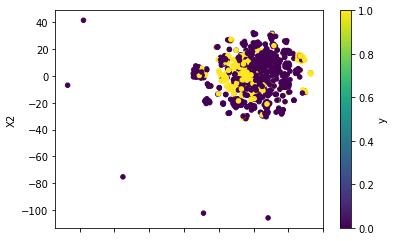

In [50]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')

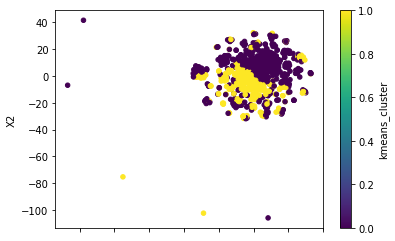

In [51]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="kmeans_cluster", colormap='viridis')

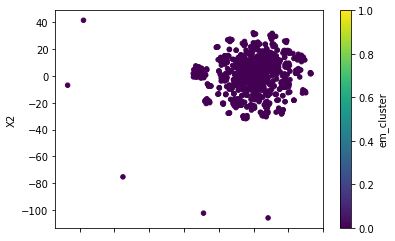

In [52]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="em_cluster", colormap='viridis')

# Principal Component Analysis

In [26]:
pca = PCA(random_state=2).fit(X_train)
pd.DataFrame(pca.explained_variance_).to_csv("pca_explained_variance.csv")

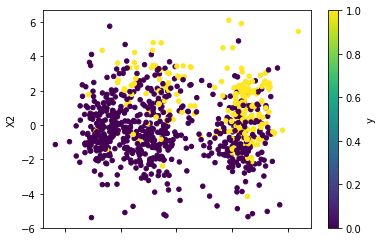

In [27]:
pca = PCA(random_state=2, n_components=2).fit_transform(X_train)
pca = pd.DataFrame(pca, columns=["X1","X2"]).assign(y = np.array(y_train))
pca.plot.scatter(x='X1', y='X2', c='y', colormap='viridis')

# Independent Component Analysis

In [56]:
n_components = [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]

kurtosis = {'n' : [], 'kurtosis': []}
for n in n_components:
    ica = FastICA(random_state=34, n_components=n).fit_transform(X_train)
    kurtosis['n'].append(n)
    kurtosis['kurtosis'].append(pd.DataFrame(ica).kurt().abs().mean())
    
kurtosis = pd.DataFrame(kurtosis)
kurtosis.to_csv("ica_kurtosis.csv")
kurtosis

,n,kurtosis
0,2,0.885790
1,3,2.701036
2,4,2.805432
3,5,4.287544
4,10,19.690909
5,15,19.778794
6,20,25.111751
7,25,32.378523
8,30,41.002154
9,40,85.395925


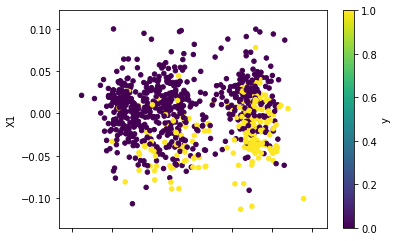

In [57]:
ica = FastICA(random_state=34, n_components=2).fit_transform(X_train)
ica = pd.DataFrame(ica, columns=["X1","X2"]).assign(y = np.array(y_train))
ica.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')

In [59]:
ica = FastICA(random_state=34, n_components=80).fit_transform(X_train)

In [60]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_ica_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(ica), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_ica_tsne = pd.concat([X_tsne, temp], sort=True)

X_ica_tsne

,X1,X2,em_cluster,kmeans_cluster,perplexity,training_time,y
0,9.882178,73.090576,0.0,1.0,2,11.035365,0.0
1,55.757908,-40.298119,0.0,1.0,2,11.035365,0.0
2,85.323471,23.548384,0.0,1.0,2,11.035365,0.0
3,-5.494154,-30.736689,0.0,1.0,2,11.035365,0.0
4,-0.041580,18.407925,0.0,1.0,2,11.035365,1.0
5,-93.504684,-24.976200,0.0,1.0,2,11.035365,0.0
6,-32.600037,-46.834698,0.0,0.0,2,11.035365,0.0
7,61.136269,-53.293407,0.0,1.0,2,11.035365,0.0
8,80.140923,32.206047,0.0,1.0,2,11.035365,1.0
9,-13.958434,-96.427422,0.0,1.0,2,11.035365,0.0


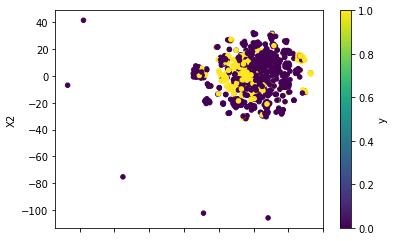

In [70]:
X_ica_tsne[X_ica_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')